## 1) Carregando o Dataset

In [2]:
from pathlib import Path
import pandas as pd

# A função pd.read_csv() lê o arquivo e o carrega em um DataFrame do pandas.
DATA_PATH = Path.cwd().joinpath(Path("Exercicio01/dataset/data_0460_5832.csv"))
df = pd.read_csv(DATA_PATH)

# O comando .head() mostra as 5 primeiras linhas do DataFrame.
print("Primeiras 5 linhas do dataset:")
print(df.head())

# O comando .info() mostra um resumo técnico, incluindo os tipos de cada coluna.
print('\nInformações do DataFrame:')
df.info()

Primeiras 5 linhas do dataset:
      Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB


## 2) Tratamento dos dados

Antes de treinar nosso modelo, precisamos preparar os dados. Isso envolve:

1.  **Lidar com variáveis categóricas**: A coluna `Sex` é categórica ('Male'/'Female'). Os modelos de regressão linear requerem entradas numéricas. Usaremos uma técnica chamada *one-hot encoding* para converter essa coluna em colunas numéricas (0s e 1s).
2.  **Definir Features (X) e Target (y)**: Separaremos nosso conjunto de dados em:
    * `X`: a matriz de features (as variáveis que usaremos para fazer a previsão).
    * `y`: o vetor alvo (a variável que queremos prever, neste caso, `Weight`).

In [3]:
import numpy as np

# Copiar o df original para não sobrescrever
df_encoded = df.copy()

# Identificar colunas categóricas que só têm dois valores
for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
    valores = df_encoded[col].dropna().unique()
    if len(valores) == 2:
        # mapear automaticamente para 0/1
        mapping = {valores[0]: 0, valores[1]: 1}
        df_encoded[col] = df_encoded[col].map(mapping)
        print(f"Coluna {col} mapeada para {mapping}")
    else:
        df_encoded.drop(columns=[col], inplace=True)
# remove colunas constantes
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if df_encoded[c].nunique(dropna=True) > 1]


Coluna Sex mapeada para {'Female': 0, 'Male': 1}


## 3) Regressão Logística

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

# ---------- split estratificado (NumPy) ----------
def stratified_split(X, y, test_size=0.3, seed=0):
    """
    Split estratificado simples para duas classes (0/1).
    Retorna: X_tr, X_te, y_tr, y_te
    """
    rng = np.random.RandomState(seed)
    X = np.asarray(X, float)
    y = np.asarray(y, int).ravel()
    assert set(np.unique(y)) <= {0,1}, "y deve ser binário {0,1}"

    idx0 = np.where(y == 0)[0]; rng.shuffle(idx0)
    idx1 = np.where(y == 1)[0]; rng.shuffle(idx1)

    n0_te = int(round(len(idx0)*test_size))
    n1_te = int(round(len(idx1)*test_size))

    te_idx = np.r_[idx0[:n0_te], idx1[:n1_te]]
    tr_idx = np.r_[idx0[n0_te:], idx1[n1_te:]]
    rng.shuffle(te_idx); rng.shuffle(tr_idx)

    return X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]

# ---------- padronização  ----------
def standardize_fit(X):
    mu = X.mean(axis=0)
    std = X.std(axis=0, ddof=0)
    std = np.where(std < 1e-12, 1.0, std)  # evita divisão por ~0
    return mu, std

def standardize_transform(X, mu, std):
    return (X - mu)/std

# ---------- métricas ----------
def binary_metrics(y_true, y_pred):
    """
    y_true, y_pred: arrays 0/1
    Retorna dict com acc, prec, rec, f1, conf_mat
    """
    y_true = np.asarray(y_true, int).ravel()
    y_pred = np.asarray(y_pred, int).ravel()
    assert y_true.shape == y_pred.shape

    tp = int(np.sum((y_true==1) & (y_pred==1)))
    tn = int(np.sum((y_true==0) & (y_pred==0)))
    fp = int(np.sum((y_true==0) & (y_pred==1)))
    fn = int(np.sum((y_true==1) & (y_pred==0)))

    acc  = (tp + tn) / max(1, tp+tn+fp+fn)
    prec = tp / max(1, tp+fp)
    rec  = tp / max(1, tp+fn)
    f1   = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
    cm   = np.array([[tn, fp],
                     [fn, tp]], dtype=int)
    return {"acc":acc, "prec":prec, "rec":rec, "f1":f1, "conf_mat":cm}

def roc_curve_np(y_true, y_score, n_thresh=200):
    """
    Curva ROC sem sklearn.
    y_true: 0/1; y_score: probabilidade p(y=1)
    Retorna fpr, tpr, thresholds e auc
    """
    y_true = np.asarray(y_true, int).ravel()
    y_score = np.asarray(y_score, float).ravel()
    # thresholds do 0 ao 1 (inclui extremos)
    thresholds = np.linspace(1, 0, num=n_thresh, endpoint=True)
    tpr_list, fpr_list = [], []
    P = np.sum(y_true==1); N = np.sum(y_true==0)
    P = max(1, P); N = max(1, N)

    for thr in thresholds:
        y_hat = (y_score >= thr).astype(int)
        tp = np.sum((y_true==1) & (y_hat==1))
        fp = np.sum((y_true==0) & (y_hat==1))
        tpr_list.append(tp/P)
        fpr_list.append(fp/N)

    # AUC por regra do trapézio
    fpr = np.array(fpr_list); tpr = np.array(tpr_list)
    auc = float(np.trapz(tpr, fpr))
    return fpr, tpr, thresholds, auc

In [10]:
class LogisticReg(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear = nn.Linear(d, 1)  # w0 é o bias

    def forward(self, X):
        # retorna logits
        return self.linear(X)

def train_logreg_torch(X_tr, y_tr, X_te, y_te, *,
                       lr=1e-2, epochs=500, seed=0, device="cpu"):
    """
    X_tr, X_te: np.ndarray padronizados
    y_tr, y_te: arrays {0,1}
    Retorna: model, history(dict), outputs (probas e preds no teste)
    """
    torch.manual_seed(seed); np.random.seed(seed)

    Xtr = torch.tensor(X_tr, dtype=torch.float32, device=device)
    Xte = torch.tensor(X_te, dtype=torch.float32, device=device)
    ytr = torch.tensor(y_tr.reshape(-1, 1), dtype=torch.float32, device=device)

    model = LogisticReg(d=X_tr.shape[1]).to(device)
    crit  = nn.BCEWithLogitsLoss()
    opt   = optim.Adam(model.parameters(), lr=lr)

    hist_loss, hist_acc = [], []

    for ep in range(1, epochs+1):
        model.train()
        opt.zero_grad()
        logits = model(Xtr)                    # (N,1)
        loss   = crit(logits, ytr)             # BCE nos logits
        loss.backward()
        opt.step()

        with torch.no_grad():
            prob = torch.sigmoid(logits).cpu().numpy().ravel()
            pred = (prob >= 0.5).astype(int)
            acc  = (pred == y_tr).mean()

        hist_loss.append(float(loss.detach().cpu()))
        hist_acc.append(float(acc))

    # ---- avaliação em teste
    model.eval()
    with torch.no_grad():
        logits_te = model(Xte)
        prob_te   = torch.sigmoid(logits_te).cpu().numpy().ravel()
        pred_te   = (prob_te >= 0.5).astype(int)

    history = {"loss": hist_loss, "acc": hist_acc}
    return model, history, {"prob_te": prob_te, "pred_te": pred_te}

acc=0.922 | prec=0.912 | rec=0.981 | f1=0.945
Matriz de confusão (linhas=verdadeiro [0,1], cols=previsto [0,1]):
 [[19  5]
 [ 1 52]]
AUC = 0.983


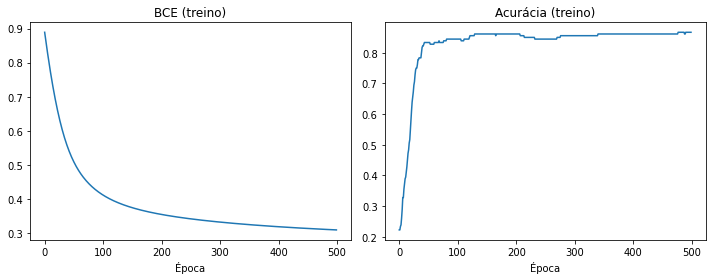

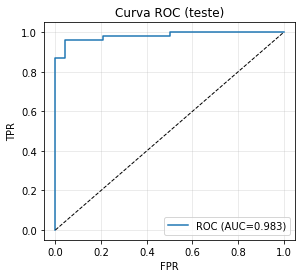

In [12]:
# ---------  escolha do target e features  ----------
TARGET = "Sex"       # coluna binária 0/1
FEATS  = [c for c in df_encoded.columns if c != TARGET]

X = df_encoded[FEATS].to_numpy(dtype=float)
y = df_encoded[TARGET].to_numpy(dtype=int)

# --------- split estratificado + padronização (sem sklearn) ----------
X_tr, X_te, y_tr, y_te = stratified_split(X, y, test_size=0.3, seed=0)
mu, std = standardize_fit(X_tr)
X_tr_n = standardize_transform(X_tr, mu, std)
X_te_n = standardize_transform(X_te, mu, std)

# --------- treino no PyTorch ----------
model, history, out = train_logreg_torch(
    X_tr_n, y_tr, X_te_n, y_te,
    lr=1e-2, epochs=500, seed=0, device="cpu"
)

prob_te = out["prob_te"]; pred_te = out["pred_te"]

# --------- métricas e gráficos ----------
m = binary_metrics(y_te, pred_te)
print(f"acc={m['acc']:.3f} | prec={m['prec']:.3f} | rec={m['rec']:.3f} | f1={m['f1']:.3f}")
print("Matriz de confusão (linhas=verdadeiro [0,1], cols=previsto [0,1]):\n", m["conf_mat"])

fpr, tpr, thr, auc = roc_curve_np(y_te, prob_te)
print(f"AUC = {auc:.3f}")

# Curvas de treino (loss/acurácia)
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history["loss"]); ax[0].set_title("BCE (treino)"); ax[0].set_xlabel("Época")
ax[1].plot(history["acc"]);  ax[1].set_title("Acurácia (treino)"); ax[1].set_xlabel("Época")
plt.tight_layout(); plt.show()

# ROC
plt.figure(figsize=(4.5,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1],[0,1], 'k--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Curva ROC (teste)")
plt.legend(); plt.grid(alpha=.3); plt.show()